In [1]:
import pandas as pd
import numpy as np
import torch

In [2]:
df = pd.read_feather('df.feather')

In [3]:
SAMPLES_PER_DAY = 4
DAYS_PER_YEAR = 365.25
YEARS = 1
RECONSTRUCTION_LENGTH = int(YEARS*(DAYS_PER_YEAR*SAMPLES_PER_DAY))

In [4]:
lats = df.lat.unique()
lons = df.lon.unique()
grids = df[['lat','lon']][~df[['lat','lon']].duplicated()].copy()
grids.reset_index(drop=True, inplace=True)

freqs = np.fft.rfftfreq(RECONSTRUCTION_LENGTH, 1/(DAYS_PER_YEAR*SAMPLES_PER_DAY) )

In [5]:
# TODO add this to preprocessing
# ((1/4)*24*60*60) * m.precipitation_rate.sum() / ((max(m.time) - min(m.time)) / '365.25 days')

# Convert pressure from Pascals to hectopascals aka millibars
df['air_pressure'] = df['air_pressure'].divide(100)

In [6]:
def easting_to_westing(coords):
    """Take strictly positive longitude <360 and make abs(lon) <= 180"""
    if coords[1] > 180.:
        return (coords[0], coords[1] - 360.)
    else: 
        return coords

def westing_to_easting(coords):
    """Take abs(lon) <= 180 and make strictly positive longitude <360"""
    if coords[1] < 0:
        return (coords[0], coords[1] + 360.)
    else: 
        return coords
def see_point_on_map(coords):
    if coords[1] > 180: coords = easting_to_westing(coords)
    print(f'https://www.google.com/maps/search/?api=1&query={coords[0]},{coords[1]}')


In [7]:
def specific_humidity_to_relative_humidity(qair, temp, press):
    """
    straight from https://earthscience.stackexchange.com/a/2385
    https://github.com/PecanProject/pecan/blob/master/modules/data.atmosphere/R/metutils.R#L15-L35
    """
    es = 6.112 * np.exp((17.67 * temp) / (temp + 243.5))
    e = qair * press / (0.378 * qair + 0.622)
    rh = e / es
    rh[rh > 1] = 1
    rh[rh < 0] = 0
    return rh

In [8]:
df['relative_humidity'] = specific_humidity_to_relative_humidity(df['specific_humidity'], df['air_temperature'], df['air_pressure'])

In [9]:
df.drop(['air_pressure','specific_humidity'],axis=1,inplace=True)
#df.drop(['air_pressure'],axis=1,inplace=True)

In [10]:
variables = list(df.columns[3:])

In [11]:
variables

['air_temperature', 'precipitation_rate', 'relative_humidity']

In [12]:
# calculate stats
means = df.groupby(['lat','lon']).mean()
means.columns = [f'mean_{c}' for c in means.columns]
grids = pd.merge(grids, means, left_on=['lat','lon'], right_index=True, how='left')

In [15]:
# see_point_on_map(coords)
# see_point_on_map((lats[nearest_lat], lons[nearest_lon]))

In [16]:
#years = 

In [17]:
#subset = create_subset(m, YEARS)

In [18]:
#subset.shape

In [19]:
## begin backprop

In [20]:
#ft = torch.rfft(x, signal_ndim=1, onesided=True, normalized=True)#.view(-1,SAMPLES_PER_DAY)

In [21]:

# keeps = (np.mod(freqs, 1) == 0) & ((freqs <=366)|(freqs==730))

In [22]:
def fft(values):
    ft = torch.rfft(values, signal_ndim=1, onesided=True, normalized=True)
    if (YEARS % 2 == 0):
        return ft.view(-1,RECONSTRUCTION_LENGTH+2)
    else:
        return ft.view(-1,RECONSTRUCTION_LENGTH+1)

In [23]:
def tensorify(subset, variables):
    fts=[]
    for v in variables:
        ft = fft(torch.from_numpy(subset[v].values))
        fts.append(ft)
    t = torch.cat(fts, 1)
    return t

In [24]:
def untensorify(t, freqs, variables):
    fts = torch.chunk(t, 4, 1)
    cols = []
    for ft in fts:
        c = torch.irfft(ft.view(-1,len(freqs),2), signal_ndim=1, normalized=True)
        cols.append(c.numpy()[0])
    df = pd.DataFrame(dict(zip(variables, cols)), pd.RangeIndex(RECONSTRUCTION_LENGTH))
    return df

In [25]:
# tensor = tensorify(subset, variables)
# recons = untensorify(tensor, freqs, variables)

In [29]:
# def create_subset(m, years):
#     """
#     Actual subset of data from a span of n years
#     """
#     r = np.random.randint(0,m.shape[0]-RECONSTRUCTION_LENGTH)
#     subset = m[r:r+RECONSTRUCTION_LENGTH]
#     return r, subset

In [30]:
def bootstrap_signatures(single_site, variables, samples_per_site=10):
    """
    Resample over various time periods 
    """
    idxs = list()
    sigs = list()
    for s in range(samples_per_site):
        r = np.random.randint(0,single_site.shape[0]-RECONSTRUCTION_LENGTH)
        subset = single_site[r:r+RECONSTRUCTION_LENGTH]
        sig = tensorify(subset, variables)
        idxs.append((subset.index.min(),subset.index.max()))
        sigs.append(sig)
    
    bs = pd.DataFrame({
        'idx': idxs,
        'sig': sigs,
    })
    
    return bs

In [31]:
#chosen_grids = np.random.choice(grids.index, size=10, replace=False)

In [32]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(copy=False)

#scaled = pd.DataFrame(, columns=df.columns, index=df.index)

In [33]:
df.loc[:,variables] = scaler.fit_transform(df[variables])

In [34]:
#for ch in chosen_grids:
#lat, lon = grids.loc[ch]
# this lookup takes a long time.. :(
#single_site = df[(df.lat==lat) & (df.lon==lon)]
bs = df.groupby(['lat','lon']).apply(bootstrap_signatures, variables=variables)

In [35]:
A = torch.cat(tuple(bs['sig'])).numpy()

In [36]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=2, random_state=42)
rdc = pd.DataFrame(svd.fit_transform(A), columns=['x1','x2'])

In [37]:
labels = bs['idx'].reset_index()
rdc['lat'], rdc['lon'] = labels['lat'], labels['lon']

In [38]:
latent_coords = rdc.groupby(['lat','lon']).median()
grids = pd.merge(grids, latent_coords, left_on=['lat','lon'], right_index=True, how='left')

In [42]:
svd.explained_variance_ratio_

array([0.42044397, 0.15757661])

In [43]:
koppen = pd.read_csv(
    'Koeppen-Geiger-ASCII.txt', sep='\s+',
    names=['lat', 'lon', 'cls'], skiprows=1,
    dtype= {'lat':np.float16,'lon':np.float16,'cls':'category'}
)

In [44]:
climate = ['Af', 'Am', 'As', 'Aw', 'BSh', 'BSk', 'BWh', 'BWk', 'Cfa', 'Cfb','Cfc', 'Csa', 'Csb', 'Csc', 'Cwa','Cwb', 'Cwc', 'Dfa', 'Dfb', 'Dfc','Dfd', 'Dsa', 'Dsb', 'Dsc', 'Dsd','Dwa', 'Dwb', 'Dwc', 'Dwd', 'EF','ET', 'Ocean']
colors = ['#960000', '#FF0000', '#FF6E6E', '#FFCCCC', '#CC8D14', '#CCAA54', '#FFCC00', '#FFFF64', '#007800', '#005000', '#003200', '#96FF00', '#00D700', '#00AA00', '#BEBE00', '#8C8C00', '#5A5A00', '#550055', '#820082', '#C800C8', '#FF6EFF', '#646464', '#8C8C8C', '#BEBEBE', '#E6E6E6', '#6E28B4', '#B464FA', '#C89BFA', '#C8C8FF', '#6496FF', '#64FFFF', '#F5FFFF']

In [45]:
def make_coords(g):
    return easting_to_westing((g['lat'],g['lon']))

In [46]:
def get_koppen(coords, koppen):
    idxmin = (abs(koppen['lat'].subtract(coords[0])) + abs(koppen['lon'].subtract(coords[1]))).idxmin()
    return koppen.loc[idxmin, 'cls']

In [47]:
grids['coords'] = grids.apply(make_coords,axis=1)
grids['koppen'] = grids['coords'].apply(get_koppen, koppen=koppen)
grids['koppen'] = grids['koppen'].astype('category')

In [50]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

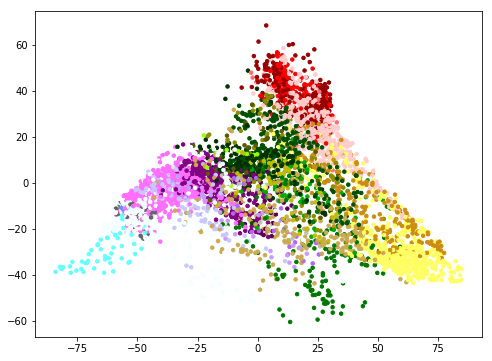

In [53]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(
    grids.x1, grids.x2,
    s=12,
    c=grids.koppen.cat.codes,
    cmap=ListedColormap(colors)
)

In [54]:
# df.loc[:,variables] = scaler.inverse_transform(df[variables])

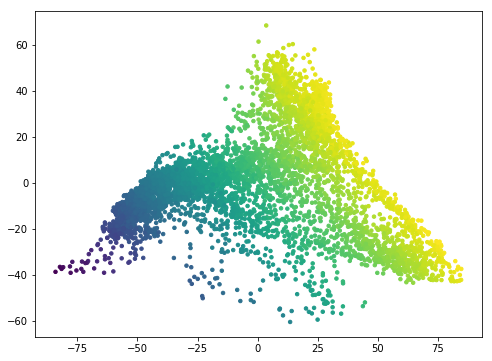

In [55]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(
    grids.x1, grids.x2,
    s=12,
    c=grids.mean_air_temperature
)

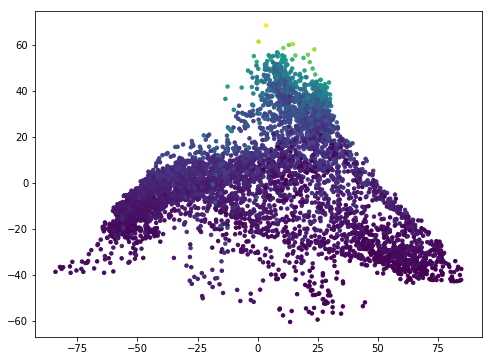

In [56]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(
    grids.x1, grids.x2,
    s=12,
    c=grids.mean_precipitation_rate
)

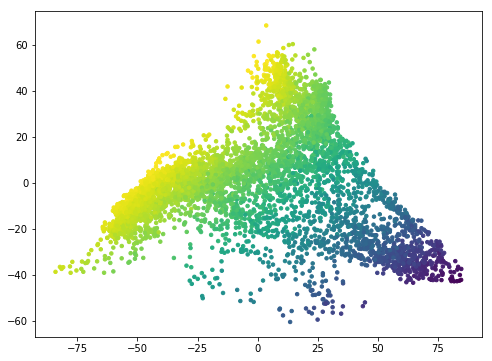

In [57]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(
    grids.x1, grids.x2,
    s=12,
    c=grids.mean_relative_humidity
)

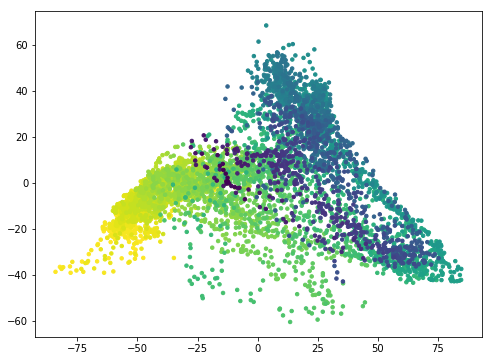

In [58]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(
    grids.x1, grids.x2,
    s=12,
    c=grids.lat
)